# Librairies

In [3]:
import glob
from pathlib import Path
import os
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import geopandas as gpd

from PIL import Image, ImageMath

import math

import warnings
import logging


import keras
from keras.layers import Input, Dense, Conv1D, Conv2D, concatenate, Flatten, MaxPooling2D, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import adam, rmsprop, sgd
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.regularizers import l1 
    
from keras.callbacks import EarlyStopping, ModelCheckpoint


from numpy.random import seed
seed(1)


/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Parameters

In [4]:
#Grid size + response variable 
gridSize=250
verbose = False
resp="v_CA16_406" #v_CA16_2540:poverty -- v_CA16_406:pop_density per sq km
finalNonLin = "sigmoid" if resp == "v_CA16_2540" else "relu" #final non-linearity: sigmoid is normalize vs relu otherwise
idGrid="gridId"
ubNumTotal = 4*10**3 #use this upper bound, otherwise it is impossible to load all images into anarray => should most likey think of some better data pipeline where we load batches of images eachtimeS

In [5]:
#Path to out put figures
figuresOutputPath = Path("." ) / ".." / "Figures" / str(gridSize )

if not os.path.exists(figuresOutputPath):
    print(f"Creating directory {figuresOutputPath}")
    os.makedirs(figuresOutputPath)
else:
    print(f"Directory {figuresOutputPath} already exists")

Directory ../Figures/250 already exists


In [6]:
#Path to output tmp models
modelsOutputPath = Path("." ) / ".." / "Data" / "Models" / str(gridSize )

if not os.path.exists(modelsOutputPath):
    print(f"Creating directory {modelsOutputPath}")
    os.makedirs(modelsOutputPath)
else:
    print(f"Directory {modelsOutputPath} already exists")

Directory ../Data/Models/250 already exists


In [7]:
#Path to save the history as a csv
historyOutputPath = Path("." ) / ".." / "Data" / "Hitory" / str(gridSize )

if not os.path.exists(historyOutputPath):
    print(f"Creating directory {historyOutputPath}")
    os.makedirs(historyOutputPath)
else:
    print(f"Directory {historyOutputPath} already exists")

Directory ../Data/Hitory/250 already exists


In [8]:
#Path to census shp file
shpFilePath = Path(".") / ".." /  "Data" / "GeoData" / "Shp" / "shpCensusMtl.shp"

In [9]:
#Parameters for conv net
lr = 5*10**-3 #watch out for small lr
numEpochs=5 # 
batchSize=2**4 #32 -- too large and this results in RAM problems

l1Coeff = 0 #10**-3
dropoutRate=0 #0.6

convNetName = "CustomConv"

verbose=True

In [10]:
#Params for custom model
filterSize={}
filterSize[0] = 7
filterSize[1] = 5
filterSize[2] = 3
    
poolSize={}
poolSize[0] = 3    
poolSize[1] = 3  
poolSize[2] = 3   

In [11]:
# model name
mdlId = f"{resp}_{convNetName}_gridSize_{gridSize}_lr_{lr}_batchSize_{batchSize}_numEpochs_{numEpochs}_l1Coeff_{l1Coeff}_dropoutRate_{dropoutRate}"
mdlId

'v_CA16_406_CustomConv_gridSize_250_lr_0.005_batchSize_16_numEpochs_5_l1Coeff_0_dropoutRate_0'

In [12]:
#Logger 
logBasePath=Path("." ) / ".." / "Log"
logger = logging.getLogger('convNetPred')
hdlr = logging.FileHandler(logBasePath / f"log_{date.today()}_{mdlId}.txt")
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')

logger.addHandler(hdlr)
logger.warning(f"{date.today()}")

# Data input

In [13]:
pathPng=Path(".") / ".." / "Output" / str(gridSize) / "Images"
pathCsv = Path(".") / ".." / "Output" / str(gridSize) / "Csv"
listPngs=[ f for f in pathPng.glob("*.png")]

(480, 480, 3)

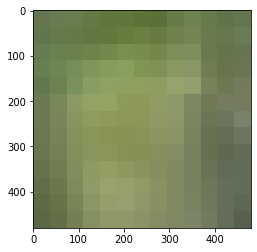

In [14]:
#Quick test
im=Image.open(listPngs[1]).convert('RGB')
plt.imshow(im)
np.array(im).shape

In [15]:
dfGrid=pd.read_csv(pathCsv / "dfGrid.csv")
print(dfGrid.shape)
dfGrid.head()

(5098, 7)


Group.1   v_CA16_2213  v_CA16_2540   v_CA16_406  gridId    GeoUID  Q_socio
0        1  28108.180617    17.431895  5030.468631       1  24660945  LaSalle
1        2  28975.027416    13.190981  8296.755560       2  24660947  LaSalle
2        3  30722.361863    18.282551  2415.326676       3  24660955  LaSalle
3        4  29286.857561    18.632622  6174.037119       4  24660957  LaSalle
4        5  32130.491182    14.183313  5569.742917       5  24660958  LaSalle

In [18]:
#Read in the census vars + gemometry
shpCensus = gpd.read_file(shpFilePath)
#fuck you pandas, merging shouldnt have to be such a pain wtf you piece of shit
shpCensus['GeoUID'] =  shpCensus['GeoUID'].astype(str).astype('int64')
shpCensus.head()

Shape_Area Type  Dwellings  Households    GeoUID  Population CD_UID  \
0     0.32098   DA        271         262  24660001         657   2466   
1     0.10672   DA        195         189  24660002         534   2466   
2     0.05993   DA        122         122  24660003         303   2466   
3     0.08228   DA        119         116  24660004         283   2466   
4     0.06276   DA         90          90  24660005         235   2466   

   CSD_UID      CT_UID CMA_UID  \
0  2466023  4620580.03   24462   
1  2466023  4620580.03   24462   
2  2466023  4620580.03   24462   
3  2466023  4620580.03   24462   
4  2466023  4620580.03   24462   

                                            geometry  
0  POLYGON ((-387500.7835405682 203119.8092380889...  
1  POLYGON ((-388010.5792480495 202579.3639201983...  
2  POLYGON ((-387936.5598988483 202646.7247733409...  
3  POLYGON ((-388272.4769774442 202325.03570621, ...  
4  POLYGON ((-388089.0671788535 202002.3662097128...

# Train test holdout split

In [19]:
numTotal = min(ubNumTotal, len(listPngs))
numTrain= math.floor(numTotal*0.8) 
numTest= numTotal - numTrain
numTotal, numTrain, numTest

(4000, 3200, 800)

In [20]:
def getIdx(sliceIdx, idGrid, resp):
    ''' Get the valid indices given a slice 
    
    params:
        sliceIdx : slide t
        idGrid: str indicating the index of each records in dfGrid
        resp: str indicating response variable
    returns:
        tuple of (np.array of indices, np.arrray of iamges - which all have the same shape)
    '''
    
    idxList=[]
    listIm=[]
    for  f in listPngs[sliceIdx] :

        #Read the image
        im= Image.open(f)
        
        if im.mode != "RGB":
            im = im.convert("RGB")
            
        #Convert to array
        array=np.array(im)
        picId = int(f.stem)
        
        #Get the response 
        dfFiltered = dfGrid.loc[ dfGrid[idGrid] == picId, resp]
        nrow = dfFiltered.shape[0]
        
        #Make sure we have all 3 rgb channels + the response is correct
        if nrow == 1 and len(array.shape) == 3 and ~np.all(np.isnan(dfFiltered)) :
            idxList.append(picId)
            listIm.append(array)
        else:
            srtrDim = ",".join( [str(s) for s in array.shape] )
            logger.warning(f"Skipping file {f.stem} - the dimensions do not match {srtrDim} - number of matches :{nrow} - resp is nan? {dfFiltered}")

                
    return np.array(idxList).astype(int), np.array(listIm)

In [21]:
idxTrain, listImTrain= getIdx( slice(0,numTrain) , idGrid, resp)
idxTest, listImTest= getIdx( slice(numTrain,numTotal), idGrid, resp)

#Get the dimension (fixed) for all images
repDim=listImTrain.shape[1:]

#Quite a bit of errors - missing reponse of error with png images
listImTrain.shape,  listImTest.shape, repDim

((3200, 480, 480, 3), (800, 480, 480, 3), (480, 480, 3))

In [22]:
#Quick validation: test and train sets must be disjoint
idxTrain[-4:], idxTest[:4]
assert( ~np.any(np.isin( idxTrain , idxTest)))
assert( ~np.any(np.isin( idxTest  , idxTrain)))

In [23]:
yTrain, yTest = dfGrid.loc[ np.isin( dfGrid[[idGrid]], idxTrain ) , resp], dfGrid.loc[ np.isin( dfGrid[[idGrid]], idxTest ) , resp]

if resp == "v_CA16_2540":
    yTrain = yTrain/100 #convert to percentage and use sigmoid transformation
    yTest = yTest/100 #convert to percentage and use sigmoid transformation
    
yTrain.head(), yTest.head()

(0    50.304686
 1    82.967556
 2    24.153267
 3    61.740371
 4    55.697429
 Name: v_CA16_406, dtype: float64, 8      30.457484
 23     32.020011
 26    100.100624
 29     46.037492
 33     21.074000
 Name: v_CA16_406, dtype: float64)

# Conv net prediction

## Build the model

In [25]:
## Layers

# Input
inputLyr= Input(shape=(  repDim ),name="input")

# 2**4 = 16 Conv + max pooling
##  params: (7x7x3+1)x16 params : (7,7) conv over 3 channels and we produce 16 feature/output maps each time + consider offset
##  output dim: (30-7+1), (30-7+1) , 16 if (30 X 30 pictures) -  (120-7+1), (120-7+1) , 16
conv2DLy1=Conv2D( 2**4, (filterSize[0],filterSize[0]),  padding="valid" , name="conv1")(inputLyr)
conv2DLy12=Conv2D( 2**4, (filterSize[0],filterSize[0]),  padding="same" , name="conv12")(conv2DLy1)
conv2DLy13=Conv2D( 2**4, (filterSize[0],filterSize[0]),  padding="same" , name="conv13")(conv2DLy12)

##  params: (3x3x3+1)x4 params : (3,3) conv over 3 channels and we produce 4 output maps each time + consider offset
##  output dim:  floor((28-3)/4)+1, floor((28-3)/4)+1, 16: (13,13,16)  if (30 X 30)
maxPoolLy1=MaxPooling2D(  (poolSize[0],poolSize[0]), strides=2, padding="valid" , name="max1")(conv2DLy13)


# 2**5 = 32 Conv + max pooling
##  params: (3X3X4 +1) X 8 = 296
##  output dim:  ((13-3))+1, ((13-3))+1, 8: (11,11,8)
conv2DLy2=Conv2D( 2**5, (filterSize[1],filterSize[1]),  padding="valid" , name="conv2")(maxPoolLy1)  
conv2DLy22=Conv2D( 2**5, (filterSize[1],filterSize[1]),  padding="same" , name="conv22")(conv2DLy2)  
conv2DLy23=Conv2D( 2**5, (filterSize[1],filterSize[1]),  padding="same" , name="conv23")(conv2DLy22)  

##  output dim:  floor((11-3)/2)+1, floor((11-3)/2)+1, 8: (5,5,8)
maxPoolLy2=MaxPooling2D(  (poolSize[1],poolSize[1]), strides=4, padding="valid" , name="max2")(conv2DLy23)


# 2**6 = 64 Conv + max pooling
##  params: (3X3X4 +1) X 8 = 296
##  output dim:  ((13-3))+1, ((13-3))+1, 8: (11,11,8)
conv2DLy3=Conv2D( 2**6, (filterSize[2],filterSize[2]),  padding="valid" , name="conv3")(maxPoolLy2)  
conv2DLy32=Conv2D( 2**6, (filterSize[2],filterSize[2]),  padding="same" , name="conv32")(conv2DLy3)  
conv2DLy33=Conv2D( 2**6, (filterSize[2],filterSize[2]),  padding="same" , name="conv33")(conv2DLy32)  

##  output dim:  floor((11-3)/2)+1, floor((11-3)/2)+1, 8: (5,5,8)
maxPoolLy3=MaxPooling2D(  (poolSize[2],poolSize[2]), strides=6, padding="valid" , name="max3")(conv2DLy33)


#Flatten them + use these for prediction
flatLyr = Flatten(name='flatten')(maxPoolLy3)

#Just one fully connected layers 
#x = Dense(2**3, activation='relu', name='fc1')(x)
#To get a comparable number of parameters ~73K, we need to have a very small penultimate output dim 
finalDenseLyr = Dense(2**4, activation='relu', name='fc2' , activity_regularizer=l1(l1Coeff))(flatLyr) #some evidence of overfiting an poor generalsation power - try with L1 norm

dropoutLyr = finalDenseLyr if dropoutRate ==0 else Dropout(rate=dropoutRate)(finalDenseLyr) #aggressive dropout to avoid overfitting

finalOutput = Dense(1, activation=finalNonLin, name='predictions')(dropoutLyr) #only 1 class: use sigmoid

In [26]:
convNetMdlCustom = Model(inputLyr, finalOutput )
convNetMdlCustom.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 480, 480, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 474, 474, 16)      2368      
_________________________________________________________________
conv12 (Conv2D)              (None, 474, 474, 16)      12560     
_________________________________________________________________
conv13 (Conv2D)              (None, 474, 474, 16)      12560     
_________________________________________________________________
max1 (MaxPooling2D)          (None, 236, 236, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 232, 232, 32)      12832     
_________________________________________________________________
conv22 (Conv2D)              (None, 232, 232, 32)      25632     
_________

In [27]:
#Set up the optimization
optInst=sgd(lr=lr) #adam(lr=lr) 
convNetMdlCustom.compile(loss="mean_squared_error", optimizer=optInst )

In [28]:
#Early stopping for the evaluation loss
es1 = EarlyStopping(monitor='val_loss',
                    verbose=1,
                    min_delta=10**-3,
                    patience=5)

## Fit the model and eval

In [29]:
mdlFile = modelsOutputPath / f"model_{mdlId}.h5"
mdlWeights = modelsOutputPath / f"weights_{mdlId}.h5"
historyPath = historyOutputPath / f"history_{mdlId}.csv"

allFileExits = [os.path.isfile(f) for f in [mdlFile,mdlWeights,historyPath ] ]

if np.all(allFileExits) :
    
    convNetMdlCustom = keras.models.load_model(str(mdlFile)) 
    mdlHist = pd.read_csv(str(historyPath))

    
else:
    
    mdlHist = convNetMdlCustom.fit(x=listImTrain,
                                       y=yTrain.values.reshape(-1, 1),
                                       epochs=numEpochs,
                                       batch_size=batchSize,
                                       shuffle=True,
                                       validation_split=0.15,
                                       callbacks=[es1],
                                       verbose=1)

    #convert the dictionary to a dataframe to standardize behaviour
    mdlHist= pd.DataFrame(mdlHist.history)
    mdlHist.to_csv(str(historyPath))
    
    
    # Save the model - save both weights AND model
    convNetMdlCustom.save(str(mdlFile))
    convNetMdlCustom.save_weights(str( mdlWeights))




Train on 2720 samples, validate on 480 samples
Epoch 1/5





2720/2720 [==============================] - 647s 238ms/step - loss: 6148.0910 - val_loss: 1577.9357
Epoch 2/5
2720/2720 [==============================] - 642s 236ms/step - loss: 6148.0910 - val_loss: 1577.9357
Epoch 3/5
2720/2720 [==============================] - 642s 236ms/step - loss: 6148.0910 - val_loss: 1577.9357
Epoch 4/5
2720/2720 [==============================] - 642s 236ms/step - loss: 6148.0910 - val_loss: 1577.9357
Epoch 5/5
2720/2720 [==============================] - 641s 236ms/step - loss: 6148.0910 - val_loss: 1577.9357


## Plot and inspect

In [ ]:
#Inspect the new weights distribution
dense1Linear=convNetMdlCustom.get_layer("fc2").get_weights()[0]
dense2Linear=convNetMdlCustom.get_layer("predictions").get_weights()[0]

dense1Offset=convNetMdlCustom.get_layer("fc2").get_weights()[1]
dense2Offset=convNetMdlCustom.get_layer("predictions").get_weights()[1]

listWeights= [dense1Linear,dense1Offset,
              dense2Linear,dense2Offset]

title=["Penultimate - linear","Penultimate - offset", 
       "Last - linear", "Last - offset"]

f = plt.figure(figsize=(10,7))
f.suptitle("Distribution of weghts for 2 last fully connected layers\n\n")

for k,w in enumerate(listWeights):
    plt.subplot(2,2,(k+1))
    sns.distplot(w.ravel(), kde=False)
    numParams = len(w.ravel())
    plt.title(f"{title[k]}\nNumber of parameters: {numParams}")
    
f.tight_layout(  rect  =(0,0,1,0.9))


plt.savefig(figuresOutputPath / f"distributionLastWeights_{mdlId}.png")

In [ ]:
#PLot the objective function evolution
plt.figure(figsize=(10,5))

plt.plot( mdlHist.index, mdlHist['loss'] ,label='Train MSE')
plt.plot( mdlHist.index, mdlHist['val_loss'] ,label='Eval MSE')

plt.title(f"{convNetName} model - accuracy\n{numEpochs} epochs", fontsize=20)

plt.legend(fontsize=16 )

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax=plt.gca()
plt.xlabel(ax.get_xlabel(), fontsize=16)
plt.ylabel(ax.get_ylabel(), fontsize=16)

plt.savefig(figuresOutputPath / f"objectiveFct_{mdlId}.png")

In [ ]:
#Get the test dataset
dfGridTest = dfGrid.loc[ np.isin(dfGrid[idGrid], yTest.index) ,  ]
dfGridTest.head()

In [ ]:
#Predict values and cmpute residuals
df = dfGridTest
df['pred'] = convNetMdlCustom.predict(listImTest) 
df["obs"] = yTest.values
df['predError'] = [ y-p for y,p in zip(df["obs"],df["pred"]) ]
np.sum(df['predError']**2)**0.5

In [ ]:
#Get the average resp and compare with predictions
avgObs = np.mean(df['obs'])
var = np.sum((df['obs']-avgObs)**2)**0.5 #this also gives an indication of the mse of predicting 0
avgObs ,var

In [ ]:
#Sort by prediction error for plotting
df.sort_values(by=["predError", "obs"], inplace=True)
df.reset_index(inplace=True)
df.head()

In [ ]:
numNeigh=len(df.Q_socio.unique())

In [ ]:
import matplotlib
plt.figure(figsize=(20,15))

plt.title(f"{convNetName} model\nPrediction errors\n{numEpochs} epochs", fontsize=20)

g=sns.scatterplot(x=df.index, y="predError", hue="Q_socio" , data=df)

g.axhline(0)
 
g.legend(title = "Neighbourhood", 
         loc='lower left', 
         bbox_to_anchor=(0.05,-0.5), 
         ncol= int(math.sqrt(numNeigh)),
         fontsize=14)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()

plt.savefig(figuresOutputPath / f"sortedPredctions_{mdlId}.png")

In [ ]:
plt.figure(figsize=(20,15))

plt.title(f"{convNetName} model\nObservations vs. predictions\nAverage {resp} : {avgObs:.3}", fontsize=20)

g=sns.scatterplot(x="obs", y="pred", hue="Q_socio" ,data=df)

g.axhline(avgObs) 
    
g.legend(title = "Neighbourhood", 
         loc='lower left', 
         bbox_to_anchor=(0.05,-0.5), 
         ncol= int(math.sqrt(numNeigh)),
         fontsize=14)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()

plt.savefig(figuresOutputPath / f"obsVsPred_{mdlId}.png")

In [ ]:
plt.figure(figsize=(12,7))
dfByNeigh=df.groupby("Q_socio").agg({"predError" :"mean"}).sort_values("predError").reset_index()

g=sns.barplot(x=dfByNeigh["Q_socio"], y="predError", data=dfByNeigh, palette="coolwarm")
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [ ]:
plt.figure(figsize=(12,7))
dfByNeigh=df.groupby("Q_socio").agg({resp:"mean"}).sort_values(resp).reset_index()

plt.title("Benchmarking - Raw response by neighbourhood")
g=sns.barplot(x=dfByNeigh["Q_socio"], y=resp, data=dfByNeigh, palette="coolwarm")
_ = g.set_xticklabels(g.get_xticklabels(), rotation=90)

In [ ]:
plt.figure(figsize=(20,15))

plt.title(f"{convNetName} model\nObservations vs. prediction errors\n{numEpochs} epochs", fontsize=20)

g=sns.scatterplot(x="obs", y="predError",  hue="Q_socio" , data=df)

g.axhline(0)

g.legend(title = "Neighbourhood", 
         loc='lower left', 
         bbox_to_anchor=(0.05,-0.5), 
         ncol= int(math.sqrt(numNeigh)),
         fontsize=14)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()

plt.savefig(figuresOutputPath / f"obsVsError_{mdlId}.png")

In [ ]:
df.head()

In [ ]:
#Would be better to use some sort of spatial interpolation, rather than averaging over all grids touching the DA
dfByDA = df.groupby("GeoUID").agg({"predError" : lambda x: np.nan if x.isnull().all() else np.mean(x.dropna())}).reset_index() #wtf pandas, do I really need to implement this shit?
dfByDA['GeoUID']=dfByDA['GeoUID'].astype(str).astype('int64') #ed to convert, otherwise GeoUID is treated as an int
dfByDA.head()

In [ ]:
shpCensus['GeoUID']=shpCensus['GeoUID'].astype(str).astype('int64')
shpCensus.head()

In [ ]:
dfByDA['GeoUID'].dtypes, shpCensus['GeoUID'].dtypes

In [ ]:

shpCensusMerged  = pd.merge( shpCensus,dfByDA, how="left" )
shpCensusMerged.head(12)
np.sum(~shpCensusMerged.predError.isnull())

In [ ]:
shpCensusMergedFiltered=shpCensusMerged[ ["GeoUID", "geometry","predError"]].dropna()
shpCensusMergedFiltered

In [ ]:
#Plot the spatial distribution of the errors
shpCensusMergedFiltered.plot(column="predError", cmap='coolwarm', 
                             legend=True,figsize=(10, 10))

plt.title(f"Predicted errors by DA- test set\n{convNetName}",fontsize=20)

plt.savefig(figuresOutputPath / f"spatialErrors_{mdlId}.png")